In [1]:
import pandas
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy

tfd = tfp.distributions

In [6]:
frogs = pandas.read_csv('../data/frogs.csv', 
                        sep='\t', dtype={'density': numpy.float32,
                                         'surv': numpy.float32})

In [8]:
frogs.head()

,density,pred,size,surv,propsurv
0,10.0,no,big,9.0,0.9
1,10.0,no,big,10.0,1.0
2,10.0,no,big,7.0,0.7
3,10.0,no,big,10.0,1.0
4,10.0,no,small,9.0,0.9


In [9]:
frogs.shape

(48, 5)

# Simple Model

$$
\begin{align}
s_i &\sim \operatorname{Binomial}(n_i, p_i) && \text{likelihood}\\
\operatorname{logit}(p_i) &= \alpha_i && \text{logit}\\
\alpha_i &\sim \operatorname{Normal}(0, 5) && \text{weak prior}
\end{align}
$$

In [10]:
def logistic(p):
    return tf.math.exp(p) / (tf.math.exp(p) + 1)

In [11]:
model = tfd.JointDistributionNamedAutoBatched({
    'a': tfd.Independent(
        tfd.Normal([0.]*frogs.shape[0], 5),
          reinterpreted_batch_ndims=1),
    's': lambda a: tfd.Independent(
        tfd.Binomial(frogs['density'], probs=logistic(a)),
          reinterpreted_batch_ndims=1)
})

In [12]:
model.resolve_graph()

(('a', ()), ('s', ('a',)))

In [13]:
model.sample()

{'a': <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([-4.7417693 , -3.4140694 , -0.1833983 ,  4.345278  ,  4.391203  ,
         2.1838698 , -0.9933053 ,  5.658705  , -2.8709803 ,  0.4389488 ,
        -0.17487063, -0.64424807, -3.5015657 , -0.0203452 ,  1.1199687 ,
        -1.0276784 , -0.21653286, -8.84734   , -0.9146135 ,  7.098673  ,
        -1.7184746 ,  7.238321  , -1.0260578 , -7.8556294 , -0.88924134,
        -3.9830909 , -4.476823  , -4.0252585 , -2.9646902 ,  3.770026  ,
         3.255742  ,  3.3608212 ,  5.04218   ,  2.9295347 ,  9.033689  ,
        -9.17353   ,  1.6036332 ,  2.865448  ,  0.03811485, -1.1625475 ,
        10.320954  ,  0.75856745, -2.1714714 , -1.6168003 , -0.26447424,
        -8.963324  , -1.0019778 , -6.596542  ], dtype=float32)>,
 's': <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([ 0.,  0.,  4., 10., 10.,  8.,  1., 10.,  0.,  4.,  2.,  7.,  0.,
         3.,  8.,  1.,  7.,  0.,  5., 25.,  2., 25.,  6.,  0.,  6.,  1.,
         0.,  1.,  1., 24.

In [14]:
model.sample(2)

{'a': <tf.Tensor: shape=(2, 48), dtype=float32, numpy=
 array([[  3.6854353 ,   1.1413286 ,  -9.588061  ,   0.206684  ,
           5.075775  ,  -3.4065475 ,  -5.751588  ,   4.415668  ,
           0.8983096 ,   1.9359145 ,   3.9552345 ,   1.1253464 ,
          -6.2746215 ,   0.8161897 ,   1.7783711 ,  -8.613736  ,
          -2.5731087 ,   4.5117397 ,   5.222097  , -10.724798  ,
          -8.677655  ,   8.085016  ,   7.1264024 ,  14.208041  ,
           2.304316  ,  -1.7290435 ,  -5.976368  ,  -1.5596725 ,
          -3.3764503 ,   2.5718417 ,  -3.3836684 ,   4.1756215 ,
          -0.23071246,   3.1890159 ,   7.205015  ,  -0.5300905 ,
          -5.793743  ,   1.600331  ,   5.1945763 ,   3.6809297 ,
           1.250875  ,  -0.0655593 ,   0.7338545 ,   1.0059129 ,
          -8.286684  ,   4.324283  ,  -7.6400084 ,   4.8207707 ],
        [  2.411506  ,  -6.7441998 ,   5.9386244 ,  -0.8866585 ,
          -0.6322297 ,  -1.9215336 ,  -0.88180304,  -6.883274  ,
           2.5940804 ,  -0.3299450

In [15]:
def simple_log_prob(a):
    return model.log_prob({'a': a, 's': frogs['surv']})

In [20]:
@tf.function
def sample(n_obs, n_burn, n_chains):
    sample = model.sample(n_chains)
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=simple_log_prob,
        num_leapfrog_steps=4,
        step_size=0.2
    )
    states = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_burnin_steps=n_burn,
        num_results=n_obs,
        current_state = [sample['a']]
    )
    return states

In [21]:
states = sample(2000, 2000, 4)

/Users/dirkhesse/.venv/venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [22]:
states[1].is_accepted.numpy().mean(axis=0)

array([0.894, 0.905, 0.906, 0.902])

In [24]:
tfp.mcmc.potential_scale_reduction(states[0])

[<tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([1.0161529, 1.009125 , 1.0067198, 1.0450674, 1.0083243, 1.0051734,
        1.0097299, 1.0168728, 1.0003042, 1.0013738, 1.0004421, 1.0020232,
        1.0001974, 1.0006677, 1.0028411, 1.0054692, 1.0089613, 1.0055825,
        1.0010139, 1.0366068, 1.0055209, 1.0013164, 1.0045787, 1.0019469,
        1.0003409, 1.0004978, 1.001197 , 1.0002016, 1.0002999, 1.0007477,
        1.0004315, 1.0004797, 1.0201309, 1.0025861, 1.001002 , 1.0001978,
        1.001842 , 1.0065217, 1.0011472, 1.0018055, 1.0011798, 1.0004169,
        1.0001776, 1.0002431, 1.0002029, 1.0002508, 1.0017027, 1.0002675],
       dtype=float32)>]

In [29]:
p = logistic(states[0][0])

(array([   4.,    8.,   23.,   68.,  137.,  341.,  693., 1252., 2226.,
        3248.]),
 array([0.3579866 , 0.42218465, 0.4863827 , 0.55058074, 0.6147788 ,
        0.67897683, 0.7431749 , 0.8073729 , 0.871571  , 0.935769  ,
        0.9999671 ], dtype=float32),
 <BarContainer object of 10 artists>)

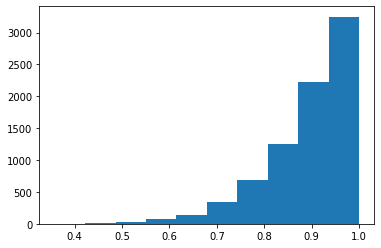

In [33]:
plt.hist(p[...,0].numpy().reshape(-1))

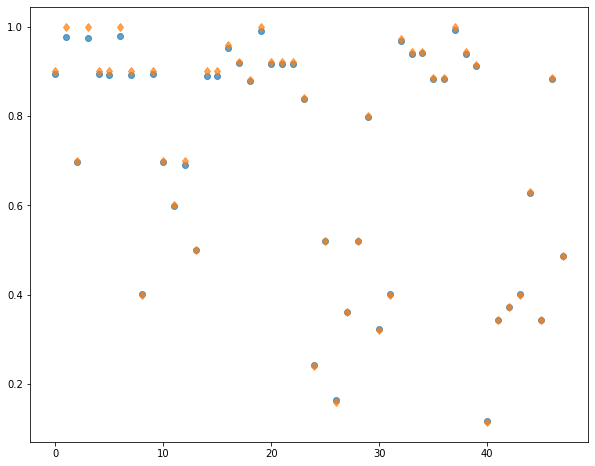

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(tf.reduce_mean(p, axis=(0, 1)), 'o', alpha=0.7)
plt.plot(frogs['propsurv'], 'd', alpha=0.7)

<ErrorbarContainer object of 3 artists>

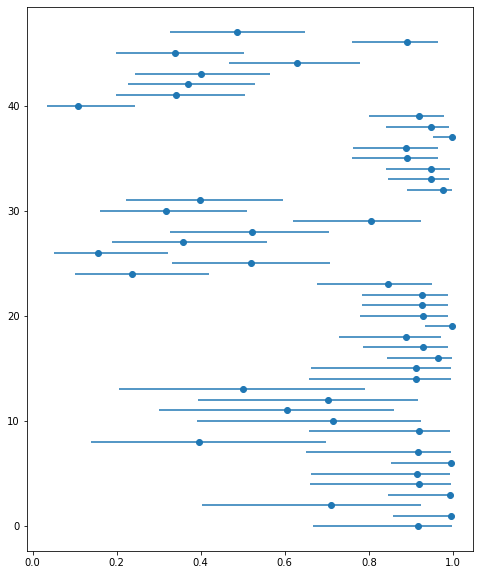

In [41]:
plt.figure(figsize=(8,10))
ci = numpy.percentile(p.numpy(), [2.5, 97.5], axis=(0, 1))
x = numpy.percentile(p.numpy(), [50], axis=(0, 1)).reshape(-1)
plt.errorbar(x, range(len(x)), xerr=(x - ci[0], ci[1] - x), marker='o', ls="")

# Pooling

$$
\begin{align}
s_i &\sim \operatorname{Binomial}(n_i, p_i) && \text{likelihood}\\
\operatorname{logit}(p_i) &= \alpha_i && \text{logit}\\
\alpha_i &\sim \operatorname{Normal}(\alpha, \sigma) && \text{pooled}\\
\sigma &\sim \operatorname{HalfCauchy}(0, 1)&& \text{prior} \\
\alpha &\sim \operatorname{Normal}(0, 1)&& \text{prior} \\
\end{align}
$$

In [50]:
model_pooled = tfd.JointDistributionNamedAutoBatched({
    'alpha': tfd.Normal(0, 1),
    'sigma': tfd.HalfCauchy(0, 1),
    'a': lambda sigma, alpha: tfd.Independent(
        tfd.Normal(tf.ones(frogs.shape[0])*alpha, sigma),
        reinterpreted_batch_ndims=1),
    's': lambda a: tfd.Independent(
        tfd.Binomial(frogs['density'], probs=logistic(a)),
        reinterpreted_batch_ndims=1)
})

In [51]:
model_pooled.resolve_graph()

(('sigma', ()), ('alpha', ()), ('a', ('sigma', 'alpha')), ('s', ('a',)))

In [52]:
model_pooled.sample()

{'sigma': <tf.Tensor: shape=(), dtype=float32, numpy=0.80062044>,
 'alpha': <tf.Tensor: shape=(), dtype=float32, numpy=-0.26392853>,
 'a': <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([-0.41335413,  0.6132736 , -1.2100937 , -0.3709726 , -1.1859998 ,
        -0.8911478 ,  0.86121464,  0.6072521 , -0.2787388 ,  0.9248103 ,
        -0.3608294 ,  0.78721964, -0.58846545,  1.419165  , -0.6939569 ,
        -1.0147042 ,  0.0966295 , -0.8939943 , -1.7848146 , -1.7434167 ,
         0.6634911 ,  0.0087468 , -2.1986911 , -0.44528365, -0.3031832 ,
        -0.4046541 ,  0.8489357 , -0.47227746, -1.0551283 , -0.48414737,
         0.11533645, -1.5882975 , -0.64484304,  1.3601872 , -1.1996788 ,
         0.7183013 ,  0.38719863,  0.29515773, -0.7330626 , -1.6470889 ,
         0.2258515 , -0.2611977 , -0.6587885 ,  0.09330893,  0.13672799,
        -1.5870094 ,  0.22466207, -0.4654862 ], dtype=float32)>,
 's': <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([ 6.,  8.,  4.,  5.,  2.,  0.,  

In [54]:
model_pooled.log_prob(model_pooled.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-139.12369>

In [55]:
model_pooled.log_prob(model_pooled.sample(3))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-191.37943,   70.47377,  -96.95217], dtype=float32)>

In [56]:
surv = tf.constant(frogs['surv'])
@tf.function
def log_prob_pooled(sigma, alpha, a):
    return model_pooled.log_prob({
        'sigma': sigma,
        'alpha': alpha,
        'a': a,
        's': surv
    })

In [57]:
log_prob_pooled(0.5, 1., [3.]*frogs.shape[0])

<tf.Tensor: shape=(), dtype=float32, numpy=-1063.5808>

In [62]:
@tf.function
def sample_pooled(n_obs, n_burn, n_chains):
    sample = model_pooled.sample(n_chains)
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_pooled,
        num_leapfrog_steps=3,
        step_size=0.1)
    states = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_burnin_steps=n_burn,
        num_results=n_obs,
        current_state=[
            sample['sigma'],
            sample['alpha'],
            sample['a']
        ]
    )
    return states

In [63]:
states_pooled = sample_pooled(5000, 5000, 4)

/Users/dirkhesse/.venv/venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [64]:
traces, kernel_res = states_pooled

In [65]:
kernel_res.is_accepted.numpy().mean(axis=0)

array([0.9554, 0.9586, 0.9622, 0.9556])

In [66]:
tfp.mcmc.potential_scale_reduction(traces)

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0098461>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0010355>,
 <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([1.0042982, 1.015103 , 1.0020475, 1.0212985, 1.021546 , 1.0163976,
        1.0142587, 1.0081049, 1.008922 , 1.0072198, 1.0142647, 1.0018705,
        1.0063492, 1.0049721, 1.014507 , 1.0059644, 1.0046567, 1.0026828,
        1.0015808, 1.0116962, 1.0072244, 1.0007612, 1.0086002, 1.0011723,
        1.002875 , 1.0047537, 1.0015492, 1.0018145, 1.0007339, 1.000601 ,
        1.0009024, 1.0009807, 1.0073454, 1.005498 , 1.0006529, 1.001961 ,
        1.0022386, 1.0054245, 1.0044445, 1.0042701, 1.0008963, 1.000812 ,
        1.0012422, 1.0008098, 1.0046204, 1.0037991, 1.0011673, 1.0020685],
       dtype=float32)>]

In [67]:
ps_pooled = logistic(traces[2])

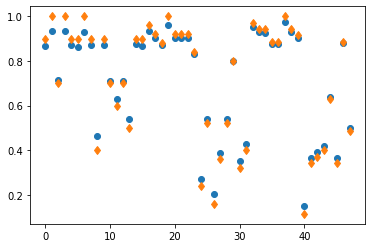

In [70]:
plt.plot(tf.reduce_mean(ps_pooled, axis=(0, 1)), 'o')
plt.plot(frogs['propsurv'], 'd')

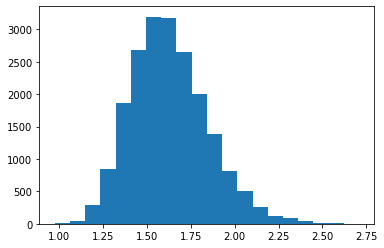

In [73]:
plt.hist(tf.reshape(traces[0], -1).numpy(), bins=20)
None

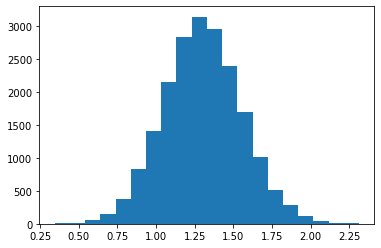

In [74]:
plt.hist(tf.reshape(traces[1], -1).numpy(), bins=20)
None

In [75]:
alpha_trace = tf.reshape(traces[1], -1)
sigma_trace = tf.reshape(traces[0], -1)

In [78]:
logits = tf.math.log(tf.ones(alpha_trace.shape) / len(alpha_trace))

In [80]:
idx = tf.random.categorical([logits], 100)

In [82]:
posterior = tfd.Normal(tf.gather(alpha_trace, idx), tf.gather(sigma_trace, idx))

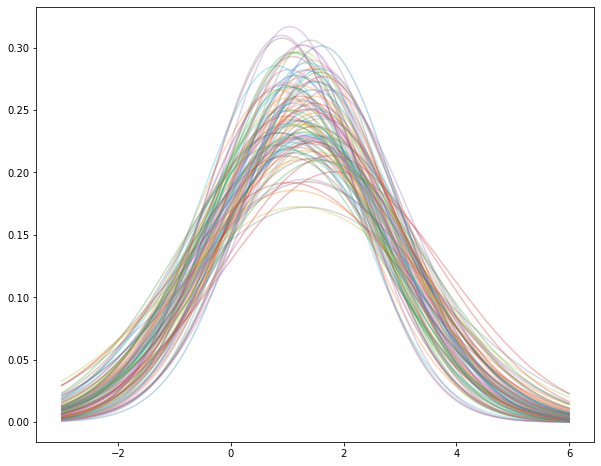

In [91]:
xs = tf.linspace(-3., 6., 200)
plt.figure(figsize=(10, 8))
plt.plot(xs, posterior.prob(xs[...,tf.newaxis]), alpha=0.3)
None

<ErrorbarContainer object of 3 artists>

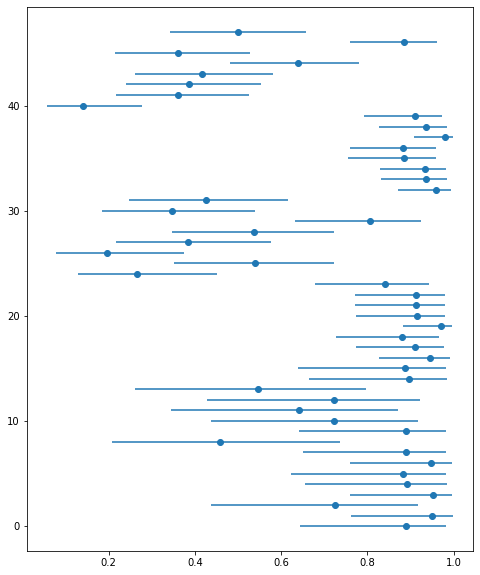

In [92]:
plt.figure(figsize=(8,10))
ci = numpy.percentile(ps_pooled.numpy(), [2.5, 97.5], axis=(0, 1))
x = numpy.percentile(ps_pooled.numpy(), [50], axis=(0, 1)).reshape(-1)
plt.errorbar(x, range(len(x)), xerr=(x - ci[0], ci[1] - x), marker='o', ls="")

# Full Model

In [98]:
big_tank = tf.constant(frogs['size'] == 'big', tf.float32)
pred = tf.constant(frogs['pred'] == 'pred', tf.float32)

In [104]:
model_full = tfd.JointDistributionNamedAutoBatched({
    'alpha': tfd.Normal(0, 1),
    'beta': tfd.Normal(0, 1),
    'gamma': tfd.Normal(0, 1),
    'sigma': tfd.HalfCauchy(0, 1),
    'a': lambda sigma, alpha, beta, gamma: tfd.Independent(
        tfd.Normal(tf.ones(frogs.shape[0])*alpha + pred*beta + big_tank*gamma
                   , sigma),
        reinterpreted_batch_ndims=1),
    's': lambda a: tfd.Independent(
        tfd.Binomial(frogs['density'], probs=logistic(a)),
        reinterpreted_batch_ndims=1)
})

In [105]:
@tf.function
def log_prob_full(alpha, beta, gamma, sigma, a):
    return model_full.log_prob({
        'sigma': sigma,
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'a': a,
        's': surv
    })

In [110]:
@tf.function
def sample_full(n_obs, n_burn, n_chains):
    sample = model_full.sample(n_chains)
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_full,
        num_leapfrog_steps=3,
        step_size=0.05)
    states = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_burnin_steps=n_burn,
        num_results=n_obs,
        current_state=[
            sample['alpha'],
            sample['beta'],
            sample['gamma'],
            sample['sigma'],
            sample['a']
        ]
    )
    return states

In [111]:
tr_full, kr_full = sample_full(4000, 3000, 4)

/Users/dirkhesse/.venv/venv/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [112]:
kr_full.is_accepted.numpy().mean(axis=0)

array([0.95425, 0.956  , 0.95175, 0.9575 ])

In [113]:
tfp.mcmc.potential_scale_reduction(tr_full)

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0252694>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0129117>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.013243>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0098689>,
 <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([1.0113516, 1.0179392, 1.0344374, 1.022122 , 1.0583062, 1.0129367,
        1.0185535, 1.0469338, 1.0093545, 1.0071726, 1.0073515, 1.0377951,
        1.0146221, 1.0359682, 1.0174997, 1.0091143, 1.0116485, 1.0107901,
        1.0073876, 1.0049034, 1.0154533, 1.0103954, 1.0034243, 1.0072567,
        1.0078378, 1.0063261, 1.0366343, 1.0022713, 1.0111064, 1.0055333,
        1.011574 , 1.0237305, 1.0155972, 1.0245949, 1.0105416, 1.0064605,
        1.0199599, 1.0067083, 1.001504 , 1.0050497, 1.0198427, 1.0075171,
        1.0019665, 1.0028712, 1.0024585, 1.0032313, 1.0075624, 1.0052632],
       dtype=float32)>]

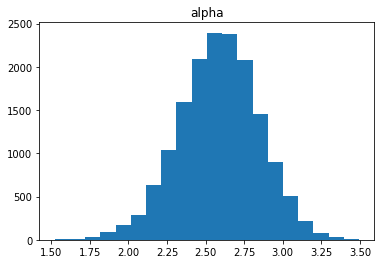

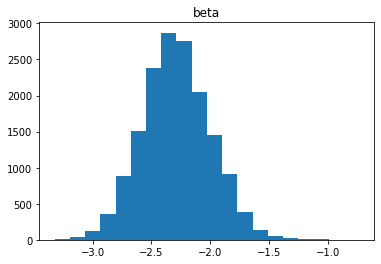

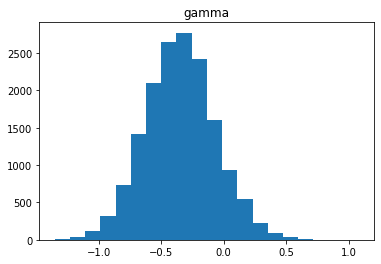

In [116]:
for i, name in enumerate(['alpha', 'beta', 'gamma']):
    plt.figure()
    plt.hist(tr_full[i].numpy().reshape(-1), bins=20)
    plt.title(name)

In [117]:
numpy.percentile(tr_full[2], [2.5, 50, 97.5])

array([-0.88282976, -0.35313243,  0.21793674])